In [119]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../')

from matplotlib.colors import LogNorm
from src.viz import plot_trajectories, use_mpl_scatter_density, plot_transition_matrix,plot_implied_timescales
from src.io import load_dataframe, save_dataframe
from src.preprocessing import (compute_phases,split_trajectories,filter_trajectories,smooth_trajectory_savgol)
from src.embedding import Embedding
from src.embedding_position import EmbeddingPosition
from umap import UMAP
from src.preprocessing import reconstruct_trajectory_from_angles

from scipy.spatial import Voronoi, voronoi_plot_2d
from src.trajectory_utils import canonicalize_trajectory

In [378]:
df = pd.read_parquet('../data/toy_model/interim/phases.parquet')
print(df.shape)
df.head()

(99700, 10)


,x,y,z,label,frame,move_type,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,-0.232717,0.602229,1.892925,1,1,straight,2.0,1.490116e-08,-1.570796,1.570796
1,-0.465433,1.204457,3.785849,1,2,straight,2.0,0.000000e+00,-1.570796,1.570796
2,-0.698150,1.806686,5.678774,1,3,straight,2.0,0.000000e+00,1.570796,1.570796
3,-0.930867,2.408915,7.571698,1,4,straight,2.0,0.000000e+00,1.570796,1.570796
4,-1.163583,3.011144,9.464623,1,5,straight,2.0,1.490116e-08,1.570797,1.570797


/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


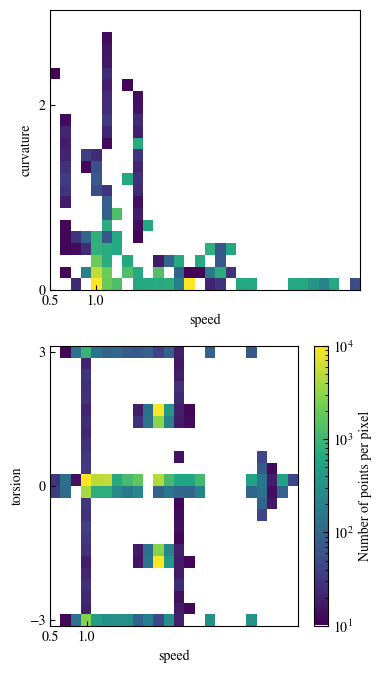

In [121]:
#plt.scatter(df[df['label'] ==1]['speed'],df[df['label'] ==1]['curvature_angle'],marker='o',alpha=0.1)
fig = plt.figure(figsize=(4,8))
norm = LogNorm(vmin=1e1,vmax=10**4)
ax1 = use_mpl_scatter_density(fig, df['speed'],df['curvature_angle'],dpi=10,norm=norm,nrows=2,pos=1,colorbar=None)
ax1.set_xlabel('speed')
ax1.set_ylabel('curvature')
ax1.set_xticks([0.5,1.])
ax1.set_yticks([0.,2.])
#ax1.grid()
ax2 = use_mpl_scatter_density(fig, df['speed'],df['torsion_angle'],dpi=10,norm=norm,nrows=2,pos=2)
ax2.set_xlabel('speed')
ax2.set_ylabel('torsion')
ax2.set_xticks([0.5,1])
ax2.set_yticks([-3,0,3])
#ax2.grid()
#fig.savefig('phase_space_toy_model.svg',transparent=True,bbox_inches='tight')

In [416]:
#emb = Embedding(df,
#                columns=['speed','curvature_angle','abs_torsion_angle'],
#                ID_NAME='label')
#emb = EmbeddingPosition(df,columns=['speed'],columns_translated=['x','y','z'],ID_NAME='label')
emb = EmbeddingPosition(df,columns=[],columns_translated=['x','y','z'],ID_NAME='label',n_subsample=10000)
#emb = Embedding(df,
#                columns=['speed','curvature_angle'],ID_NAME='label')


In [417]:
emb.make_embedding(K=20)

(array([[[ 1.90000000e+01, -3.34363388e-16,  1.52577890e-15, ...,
          -1.90000000e+01,  8.51282326e-16, -2.93165495e-15],
         [ 1.90000000e+01,  4.04090312e-15,  1.24047238e-15, ...,
          -1.90000000e+01, -2.89435667e-15, -7.40993045e-17],
         [ 1.90000000e+01,  2.29221710e-16,  9.73310349e-17, ...,
          -1.90000000e+01,  2.27930254e-18, -9.59316195e-16],
         ...,
         [ 1.90000000e+01, -3.11994172e-14,  4.58393112e-16, ...,
          -1.90000000e+01, -3.18522695e-14,  7.07012037e-15],
         [-1.90000000e+01,  7.45008041e-15,  9.41149796e-16, ...,
           1.90000000e+01,  4.11532168e-14,  4.33302255e-15],
         [-1.90000000e+01, -2.42848654e-14, -4.58361235e-15, ...,
           1.90000000e+01, -3.01982378e-14,  1.74831517e-14]],
 
        [[ 1.90000000e+01, -1.99703120e-16, -7.82720007e-17, ...,
          -1.90000000e+01, -4.49724048e-16, -7.34171584e-16],
         [ 1.90000000e+01, -3.39605513e-15, -5.43130371e-16, ...,
          -1.90000000

In [418]:
emb.make_cluster(30)#,clustering_method='polynomial_distances')

array([25, 25, 25, ..., 23, 23, 23])

In [419]:
# Label the rest by nearest center
from scipy.spatial.distance import cdist
dists = cdist(emb.flatten_embedding_matrix, emb.cluster_centers_, metric='euclidean')
emb.labels = np.argmin(dists, axis=1)
#self.cluster_centers_ = centers
#return self.labels

23
23


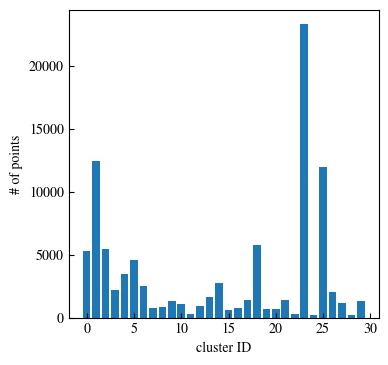

In [420]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
# Optionally, zip into a dict
cluster_counts = dict(zip(unique_labels, counts))
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(list(cluster_counts.keys()),list(cluster_counts.values()))
ax.set_xlabel('cluster ID')
ax.set_ylabel('# of points')
print(unique_labels[np.argmax(counts)])
print(np.argmax(counts))

In [421]:
reduced_points,reduced_centers = emb.fit_umap(n_neighbors=15,min_dist=0.5,with_cluster_centers=True)

/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


rng = np.random.default_rng(10973)
print(emb.flatten_embedding_matrix.shape[0])
indices = rng.choice(emb.flatten_embedding_matrix.shape[0], size=9680, replace=False)
data = emb.flatten_embedding_matrix[indices]
    
combined =np.array([])
# Concatenate data and centers before UMAP
combined = np.append(data, emb.cluster_centers_, axis=0)
reducer = UMAP(
        n_neighbors=10,
        min_dist=0.5,
        n_components=2,
        metric="euclidean",
    )
reduced_all = reducer.fit_transform(combined)
N = data.shape[0]
reduced_points = reduced_all[:N]
reduced_centers = reduced_all[N:N + emb.cluster_centers_.shape[0]]

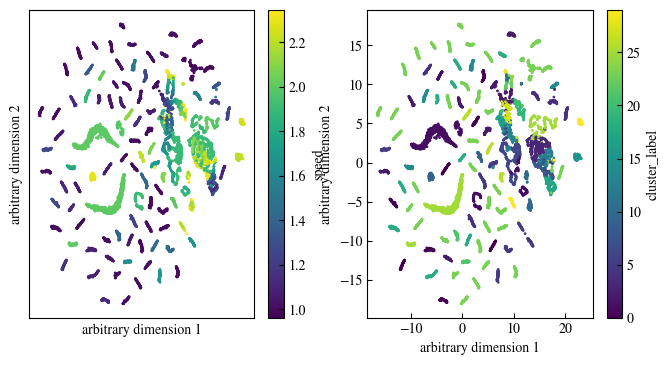

In [422]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))

speedx = emb.flatten_embedding_matrix[emb.indices,0::3][:,1:] - emb.flatten_embedding_matrix[emb.indices,0::3][:,:-1]
speedy = emb.flatten_embedding_matrix[emb.indices,1::3][:,1:] - emb.flatten_embedding_matrix[emb.indices,1::3][:,:-1]
speedz = emb.flatten_embedding_matrix[emb.indices,2::3][:,1:] - emb.flatten_embedding_matrix[emb.indices,2::3][:,:-1]
speed = np.mean(np.linalg.norm(np.array([speedx,speedy,speedz]).T,axis=2),axis=0)
color_values=speed
#color_values = np.mean(emb.flatten_embedding_matrix[indices, 0::4], axis=1)
sc = ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
    
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
cbar = fig.colorbar(sc, ax=ax[0])
cbar.set_label(r'speed')
#cbar.ax.set_yticks([])  

color_values = np.mean(emb.flatten_embedding_matrix[emb.indices, 1::3], axis=1)
color_values = emb.labels[emb.indices]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
#ax[1].set_xticks([])
#ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'cluster_label')
#cbar.ax.set_yticks([])  

#for i in range(2):
#    ax[i].set_xlim(-2,15)
#    ax[i].set_ylim(-2,10)

In [423]:
lambda_tau =[]
taus = np.array([1,2,3,4,5,10,15,20,25,30,40,50,100,200,300,500])
for tau in taus:
    emb.make_transition_matrix(tau=tau)
    eig_val,eig_vec = np.linalg.eig(emb.P.T)
    real_spectrum = np.abs(np.real(eig_val))
    # sort the eigen system according to the value of the real part
    eig_vec = eig_vec[:,np.argsort(real_spectrum)]#/np.sum(eig_vec[:,np.argsort(real_spectrum)],axis=1)
    real_spectrum = real_spectrum[np.argsort(real_spectrum)]
    lambda_tau.append(real_spectrum[-10:])
lambda_tau=np.array(lambda_tau)

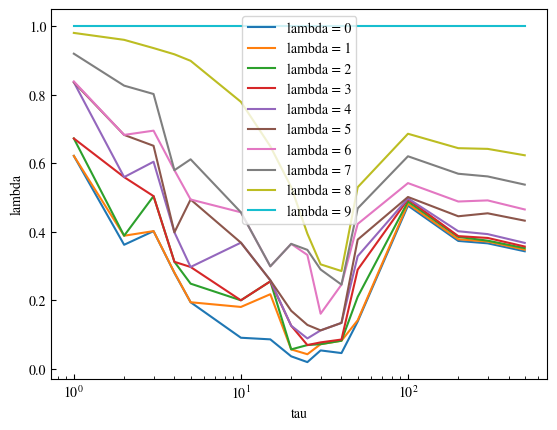

In [424]:
for i in range(min([10,eig_val.shape[0]])):
    plt.plot(taus,lambda_tau[:,i],label="lambda = "+str(i))
    plt.xscale('log')
plt.xlabel("tau")
plt.ylabel('lambda')
plt.legend()

In [425]:
emb.make_transition_matrix(tau=10)
emb.reversibilized_matrix()


val,vec = np.linalg.eig(emb.Pr.T)
vec = vec[:,np.argsort(val)]
val  = val[np.argsort(val)]
ss = np.abs(np.real(eig_vec[:,-1]))
ss = ss/np.sum(ss)

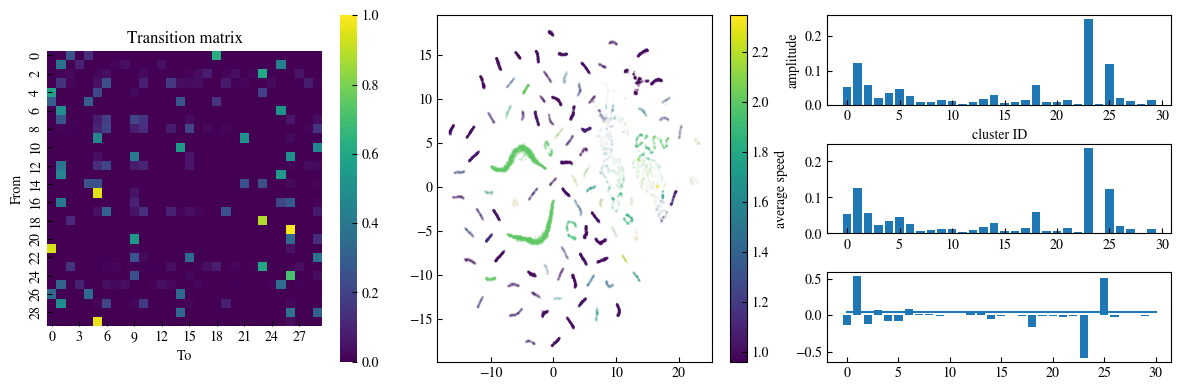

In [426]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))
count_for_color = np.array(list(cluster_counts.values()))/np.sum(list(cluster_counts.values()))

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1,1], width_ratios=[1, 1, 1])
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[:,1])
ax02 = fig.add_subplot(gs[0,2])
ax12 = fig.add_subplot(gs[1,2])
ax22 = fig.add_subplot(gs[2,2])


plot_transition_matrix(emb.P, ax=ax0)
plt.tight_layout()

color_values = speed#np.mean(emb.flatten_embedding_matrix[indices, 0::4], axis=1)
alpha = [count_for_color[lab] for lab in emb.labels[emb.indices]]
sc = ax1.scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=alpha,rasterized=True,cmap='viridis')
cbar = fig.colorbar(sc, ax=ax1)
cbar.set_label('average speed')

ax02.bar(np.arange(0,ss.shape[0],1),ss)
ax02.set_xlabel('cluster ID')
ax02.set_ylabel('amplitude')


ax12.bar(list(cluster_counts.keys()),np.array(list(cluster_counts.values()))/np.sum(list(cluster_counts.values())))

slow = np.real(vec[:,-2])
#slow = slow/np.sum(slow)
ax22.bar(np.arange(0,slow.shape[0],1),slow)
ax22.plot([0,30],[0.05,0.05])

plt.show()

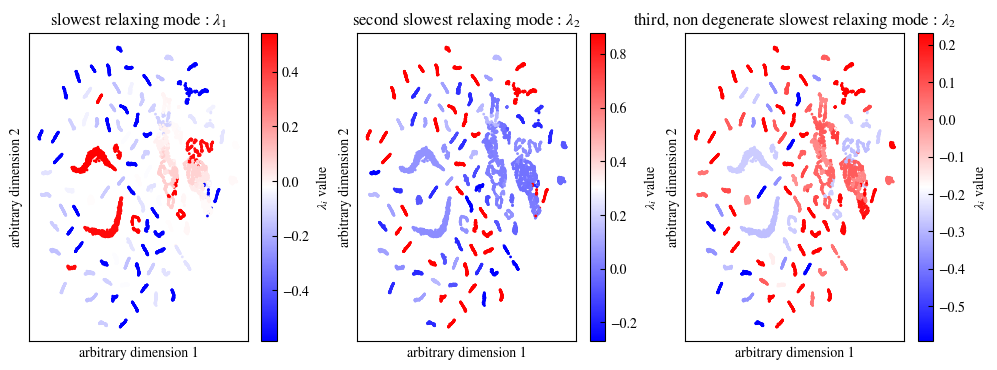

In [427]:
fig,ax = plt.subplots(ncols=3,figsize=(12,4))
slow_mode = (np.real(vec[:,-2]))
color_values = [slow_mode[lab] for lab in emb.labels[emb.indices]]
sc = ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
cbar = fig.colorbar(sc, ax=ax[0])
cbar.set_label(r'$\lambda_i$ value')

vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
ax[0].set_title(r'slowest relaxing mode : $\lambda_1$')

slow_mode = np.real(vec[:,-3])
color_values = [slow_mode[lab] for lab in emb.labels[emb.indices]]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
ax[1].set_title(r'second slowest relaxing mode : $\lambda_2$')

cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'$\lambda_i$ value')
#ax.set_yticks([])  

slow_mode = np.real(vec[:,-4])
color_values = [slow_mode[lab] for lab in emb.labels[emb.indices]]
sc = ax[2].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('arbitrary dimension 1')
ax[2].set_ylabel('arbitrary dimension 2')
ax[2].set_title(r'third, non degenerate slowest relaxing mode : $\lambda_2$')

cbar = fig.colorbar(sc, ax=ax[2])
cbar.set_label(r'$\lambda_i$ value')

#cbar.ax.set_yticks([])  
#fig.savefig('umap_color_lambda.svg',transparent=True,bbox_inches='tight')

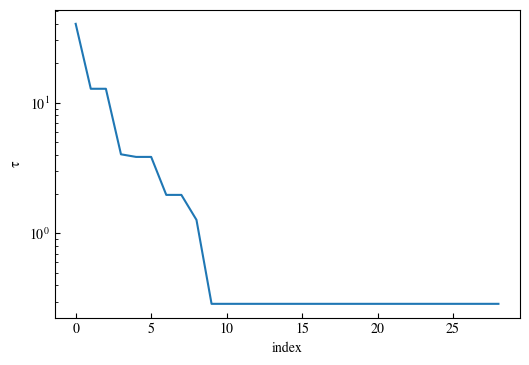

In [428]:
ts = emb.implied_timescales(tau=emb.tau)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ts,label='stoch mat')
ax.set_ylabel("τ")
ax.set_xlabel("index")
plt.yscale('log')

emb.make_transition_matrix(tau=1)
state_trajectory = list()
emb.initialize_state()
state_trajectory.append(emb.state)
for i in range(5):
    emb.make_transition()
    state_trajectory.append(emb.state)
state_trajectory=np.array(state_trajectory)
print(state_trajectory.shape)

trajectory = list()
for points in state_trajectory:
    piece_of_trajectory = emb.pick_random_trajectory_in_cluster(points)
    trajectory.append(piece_of_trajectory)
trajectory = np.array(trajectory)
print(trajectory.shape)

XYZ = np.array([[0., 0., 0.]], dtype=float)
for traj in trajectory:
    # traj assumed to be flat array of length 3N
    coords = np.array([traj[0::3], traj[1::3], traj[2::3]])  # shape (3, N)
    coords = coords.T + XYZ[-1]  # shape (N, 3) + (3,) — this broadcasts correctly
    XYZ = np.vstack([XYZ, coords])
print(XYZ.shape)

fig,ax = plt.subplots(ncols=1,figsize=(8,4),subplot_kw={'projection':'3d'})
tint = trajectory.shape[1]//2 # phase_trajectory.shape[1] contains x and y
ax.plot(XYZ[:,0],XYZ[:,1],XYZ[:,2])#,marker='o')


In [429]:
df1 = pd.read_csv('../data/toy_model/interim/longest_trajectory.csv')
df1.head()
print(df1[['x','y','z']].to_numpy().shape)
print(emb.D)
#labels = emb.classify_trajectory(trajectory_trans=df1[['x','y','z']].to_numpy(),trajectory_abs=np.array([df1['speed'].to_numpy()]).T)
labels = emb.classify_trajectory(trajectory_trans=df1[['x','y','z']].to_numpy())

(997, 3)
3


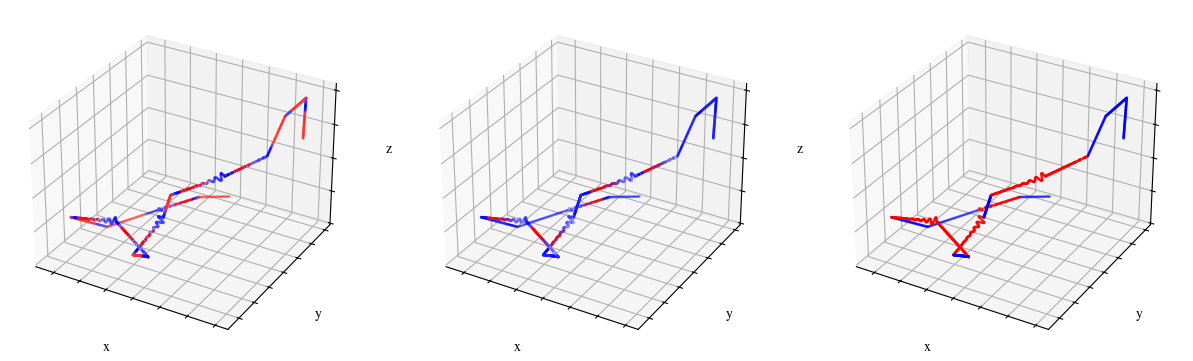

In [430]:
fig,ax = plt.subplots(ncols = 3, subplot_kw={'projection':'3d'},figsize=(15,5))

slow_mode = np.real(vec[:,-2])
color_values = [abs(slow_mode[lab]) for lab in labels]
I = color_values.__len__()
ax[0].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_zticklabels([])
ax[0].grid(True)

slow_mode = np.real(vec[:,-3])
color_values = [abs(slow_mode[lab]) for lab in labels]
I = color_values.__len__()
ax[1].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1.)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_zticklabels([])
ax[1].grid(True)

#slow_mode = np.real(eig_vec[:,-4])
#color_values = [abs(slow_mode[lab]) for lab in labels]
I = labels.shape[0]
color_dict = {"straight":0.,"cast_and_surge":1.}
color_values = np.zeros(I,dtype=float)
for i in range(color_values.shape[0]):
    color_values[i] = color_dict[df1['move_type'][i]]
ax[2].scatter(df1['x'][:I],df1['y'][:I],df1['z'][:I],c=color_values,cmap='bwr',s=1.)
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_zlabel('z')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_zticklabels([])
ax[2].grid(True)


In [431]:
print(slow_mode)

[-0.17372215  0.05838815  0.14446537 -0.0125164  -0.18242816 -0.26915855
  0.01571382 -0.00367451 -0.0163086  -0.06944177 -0.04377932 -0.00681332
 -0.00910034  0.02617208 -0.15905938 -0.03042534  0.00107574  0.00992542
  0.09365535 -0.02308043 -0.01102988 -0.0849241  -0.00455293  0.87762735
 -0.00626798  0.04608437 -0.10038952  0.01912211 -0.01038676 -0.07517031]


In [432]:
trajectory = df1[['x','y','z']].to_numpy()
L = trajectory.shape[0] - emb.K
embedded_trajectory = np.empty((L, emb.K * emb.D), dtype=float)
for t in range(L):
    embedded_trajectory[t] = canonicalize_trajectory(trajectory[t:t + emb.K]).reshape(-1)

In [433]:
print(emb.n_clusters)

30


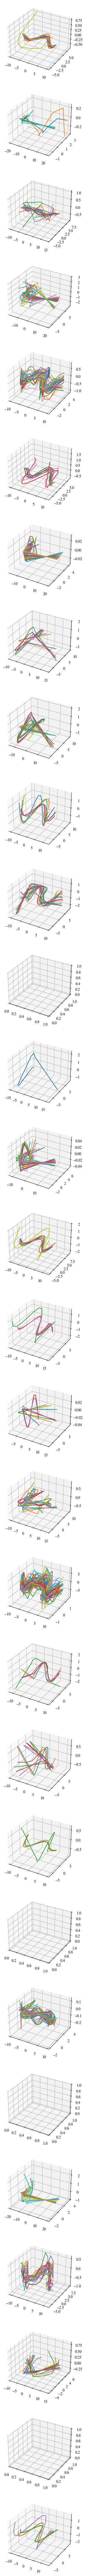

In [434]:
fig,ax = plt.subplots(nrows = emb.n_clusters,subplot_kw={'projection':'3d'},figsize=(4,4*emb.n_clusters))
for n,traj in enumerate(embedded_trajectory):
    ax[labels[n]].plot(traj[0::3],traj[1::3],traj[2::3])

<BarContainer object of 30 artists>

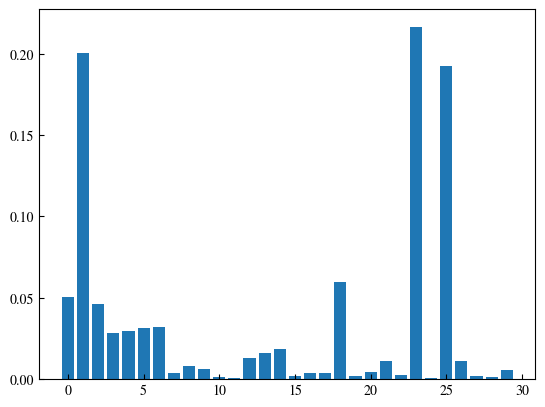

In [435]:
slow_mode = np.real(vec[:,-2])
slow_mode = abs(slow_mode)/np.sum(np.abs(slow_mode))
#slow_mode = (slow_mode - np.min(slow_mode))/(np.max(slow_mode) - np.min(slow_mode))
plt.bar(np.arange(0,slow_mode.shape[0],1),slow_mode)

In [436]:
np.cumsum(slow_mode[np.argsort(slow_mode)][::-1])

array([0.21660873, 0.41713187, 0.60937138, 0.66896705, 0.71931718,
       0.7652396 , 0.79694868, 0.82814694, 0.85772252, 0.88557857,
       0.9037618 , 0.91969309, 0.93271133, 0.94369734, 0.95462435,
       0.96270138, 0.96883018, 0.97424549, 0.97862031, 0.9824699 ,
       0.98611583, 0.98938198, 0.99177971, 0.99377329, 0.99574681,
       0.9972769 , 0.99840201, 0.99923035, 0.99965174, 1.        ])

In [437]:
from src.labeling_cluster import embed_move_type, average_out, label_clusters


In [438]:
Counter(emb.labels).keys().__len__()

30

In [439]:
embedded_stereo = embed_move_type(df,K=emb.K,ID_NAME='label')

In [440]:
embedded_counter = average_out(embedded_stereo,emb.K)

In [441]:
stereotyps = label_clusters(n_clusters = emb.n_clusters, labels = emb.labels,embedded_counter = embedded_counter)

In [442]:
print(stereotyps)
print(stereotyps[:6])


[{'straight': 0.0, 'cast_and_surge': 1.0}, {'straight': 0.9945020080321285, 'cast_and_surge': 0.005497991967871464}, {'straight': 0.017303453343130062, 'cast_and_surge': 0.98269654665687}, {'straight': 0.8895624430264352, 'cast_and_surge': 0.11043755697356476}, {'straight': 0.012542955326460478, 'cast_and_surge': 0.9874570446735395}, {'straight': 0.010441592342832247, 'cast_and_surge': 0.9895584076571677}, {'straight': 0.8831277357739751, 'cast_and_surge': 0.116872264226025}, {'straight': 0.4540053404539394, 'cast_and_surge': 0.5459946595460606}, {'straight': 0.7207683073229294, 'cast_and_surge': 0.2792316926770705}, {'straight': 0.011883408071748874, 'cast_and_surge': 0.9881165919282511}, {'straight': 0.08350091407678291, 'cast_and_surge': 0.9164990859232172}, {'straight': 0.18191126279863482, 'cast_and_surge': 0.8180887372013653}, {'straight': 0.8473765432098767, 'cast_and_surge': 0.1526234567901232}, {'straight': 0.758809234507898, 'cast_and_surge': 0.24119076549210203}, {'straight'

In [443]:
def entropy(w):
    w = np.asarray(w, dtype=float)
    w = w[w > 0]  # avoid log(0)
    return -np.sum(w * np.log(w))/np.log(len(w))


In [444]:
vals = list(stereotyps[0].values())
keys = list(stereotyps[0].keys())
print(vals)
print(keys)


[0.0, 1.0]
['straight', 'cast_and_surge']


In [445]:
entropies_clusters = list()
for stereotyp in stereotyps:
    entropies_clusters.append(entropy(list(stereotyp.values())))
entropies_clusters=np.array(entropies_clusters)

/tmp/ipykernel_16457/941181060.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return -np.sum(w * np.log(w))/np.log(len(w))


In [446]:
entropies_clusters[np.argsort(entropies_clusters)]
print(ss[np.argsort(entropies_clusters)])
print(sum(ss[:11]))

[0.05758877 0.24769453 0.12247439 0.1179112  0.04733874 0.02818293
 0.01333234 0.03573152 0.0585616  0.01448011 0.01342326 0.00760314
 0.00665783 0.00755421 0.01161365 0.02056597 0.02543181 0.01556781
 0.00923595 0.0033078  0.0022515  0.01696453 0.00219813 0.00786006
 0.01265313 0.00757059 0.00824791 0.00369442 0.02052224 0.05377994]
0.40426060343277487


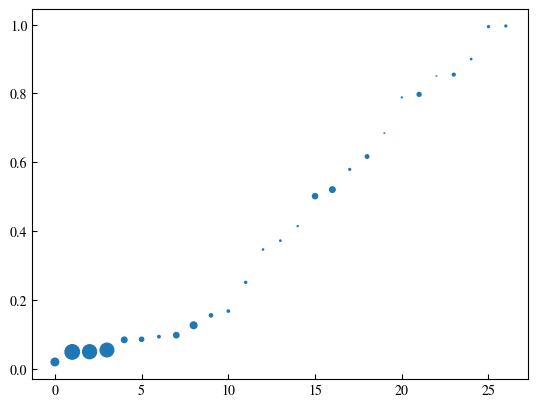

In [447]:
plt.scatter(np.arange(0,stereotyps.__len__(),1),entropies_clusters[np.argsort(entropies_clusters)],s=slow_mode[np.argsort(entropies_clusters)]*500)#ss[np.argsort(entropies_clusters)]*500)

In [448]:
classification = {'straight':0,'cast_and_surge':0}
for i in range(slow_mode.shape[0]):
    for key in stereotyps[i].keys():
        classification[key]+=stereotyps[i][key] * slow_mode[i]
print(classification)

{'straight': 0.4810136172045845, 'cast_and_surge': 0.5189863827954153}
